# Matplotlib v. OpenCV Method Comparison

This notebook is used to look at the details of the matplotlib and opencv methods in a comparative way. It's useful for debugging. It's based off the code in the examples folder.

The first cell does the imports and performs a single image data pull from the query.

The second cell performs the matplotlib code to transform, scale, and present this result.

The third cell performs the same via the opencv approach.

This enables the two to be compared easily on the same input data.

Of note; in video mode the OpenCV method seems to run MUCH faster, but the Matplotlib color schemes are more useful (and are thus applied to the OpenCV version using the cmapy library).

In [4]:
import time,board,busio
import numpy as np
import adafruit_mlx90640
import matplotlib.pyplot as plt
from matplotlib import colors
import logging, configparser
from scipy import ndimage
from util_functions import *
import datetime as dt
import cv2
import cmapy

# Setup camera
i2c = busio.I2C(board.SCL, board.SDA, frequency=800000) # setup I2C
mlx = adafruit_mlx90640.MLX90640(i2c) # begin MLX90640 with I2C comm
mlx.refresh_rate = adafruit_mlx90640.RefreshRate.REFRESH_2_HZ  # set refresh rate
frame = np.zeros(mlx_shape[0]*mlx_shape[1]) # 768 pts
mlx.getFrame(frame) # read mlx90640

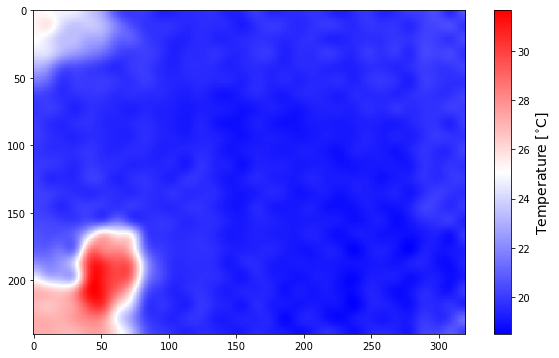

In [5]:
mlx_shape = (24,32)

# Set up figure
fig = plt.figure(figsize=(9,5)) # start figure
ax = fig.add_subplot(111) # add subplot
fig.subplots_adjust(0.05,0.05,0.95,0.95) # get rid of unnecessary padding

# Interpolate
mlx_interp_val = 10 # interpolate # on each dimension
mlx_interp_shape = (mlx_shape[0]*mlx_interp_val,
                    mlx_shape[1]*mlx_interp_val) # new shape
therm1 = ax.imshow(np.zeros(mlx_interp_shape),interpolation='none', cmap=plt.cm.bwr,vmin=25,vmax=45) # preemptive image

# Add colorbar
cbar = fig.colorbar(therm1) # setup colorbar
cbar.set_label('Temperature [$^{\circ}$C]',fontsize=14) # colorbar label

# Raw Figure
fig.canvas.draw() # draw figure to copy background
fig.show() # show the figure before blitting

# fig.canvas.restore_region(ax_background) # restore background
data_array = np.fliplr(np.reshape(frame,mlx_shape)) # reshape, flip data
data_array = ndimage.zoom(data_array,mlx_interp_val) # interpolate

therm1.set_array(data_array) # set data
therm1.set_clim(vmin=np.min(data_array),vmax=np.max(data_array)) # set bounds

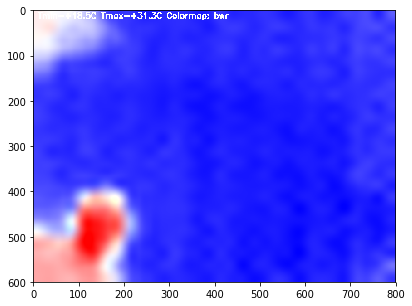

In [9]:
colormap_list=['jet','bwr','seismic','coolwarm','PiYG_r','tab10','tab20','gnuplot2','brg']
colormap=colormap_list[1] # Use index to pick colormap from the above line's list.

# function to convert temperatures to pixels on image
def temps_to_rescaled_uints(f,Tmin,Tmax):
    norm = np.uint8((f - Tmin)*255/(Tmax-Tmin))
    norm.shape = (24,32)
    return norm

image=frame
temp_min = np.min(image)
temp_max = np.max(image)
img=temps_to_rescaled_uints(image,temp_min,temp_max)     

# Image processing
img = cv2.applyColorMap(img, cmapy.cmap(colormap))
img = cv2.resize(img, (800,600), interpolation = cv2.INTER_CUBIC) #INTER_LANCZOS4) #INTER_LINEAR)
img = cv2.flip(img, 1)
text = f'Tmin={temp_min:+.1f}C Tmax={temp_max:+.1f}C Colormap: {colormap}'
cv2.putText(img, text, (10, 18), cv2.FONT_HERSHEY_SIMPLEX, .6, (255, 255, 255), 2)
# cv2.namedWindow('Thermal Image', cv2.WINDOW_NORMAL)
# cv2.resizeWindow('Thermal Image', 1200,900)
# cv2.imshow('Thermal Image', img)

# Note: The above lines had to be replaced with the below to show this in Jupyter.
# Note: CV2 uses bgr color formatting, so to display it accurately here via matplotlib it must be converted to rgb
# When run normally using the above cv2 lines the output will look the same as the below does
img=cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
fig = plt.figure(figsize=(9,5))
ax = fig.add_subplot(111) # add subplot
ax.imshow(img)